# Refactored GenAI Image Detection Solution

## Overview
This notebook implements a two-stage AI vs Human image detection pipeline:
1. **Deep Learning Stage**: Frequency-aware CNN to detect known GenAI patterns
2. **Statistical Stage**: Color histogram analysis to catch unknown GenAI models

### Key Innovations:
- 🔬 **Frequency Domain Analysis**: Uses FFT to extract GenAI artifacts in mid-frequency bands
- 🎨 **3D Color Histogram**: Statistical anomaly detection for unknown models
- 🧠 **Dual-Channel CNN**: Processes both spatial and frequency information simultaneously

In [1]:
# Core libraries
import os
import numpy as np
import pandas as pd
import cv2
from scipy import stats
from PIL import Image
import multiprocessing as mp
from random import random, choice

# PyTorch
import torch
import torch.nn as nn
import torchvision
from torchvision.transforms.v2 import functional as TF

# Metrics and utilities
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score
from tqdm.notebook import tqdm

print("✓ All imports successful")

✓ All imports successful


## 1. Setup and Imports

In [2]:
# Setup device and seed
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
SEED = 42

np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

print(f"Device: {DEVICE}")
print(f"Random seed: {SEED}")

Device: cuda
Random seed: 42


In [3]:
# Configuration
CONFIG = {
    'batch_size': 16,
    'epochs': 1,
    'lr': 3e-5,
    'img_size': 256,
    'train_samples': 5000,
    'val_samples': 1000,
    'confidence_level': 99.0,
    'freq_low': 30,
    'freq_high': 100
}

print("Configuration:")
for key, value in CONFIG.items():
    print(f"  {key}: {value}")

Configuration:
  batch_size: 16
  epochs: 1
  lr: 3e-05
  img_size: 256
  train_samples: 5000
  val_samples: 1000
  confidence_level: 99.0
  freq_low: 30
  freq_high: 100


## 2. Data Loading and Preprocessing

In [4]:
# Load datasets
base_dir = '/kaggle/input/ai-vs-human-generated-dataset'

df_train = pd.read_csv(f'{base_dir}/train.csv')
df_train['file_name'] = df_train['file_name'].apply(lambda x: os.path.join(base_dir, x))

df_test = pd.read_csv(f'{base_dir}/test.csv')
df_test['id'] = df_test['id'].apply(lambda x: os.path.join(base_dir, x))

print(f"Training samples: {len(df_train)}")
print(f"Test samples: {len(df_test)}")
print(f"\nLabel distribution:")
print(df_train['label'].value_counts())

Training samples: 79950
Test samples: 5540

Label distribution:
label
1    39975
0    39975
Name: count, dtype: int64


In [5]:
# Create train/validation split
train_data = df_train.iloc[:CONFIG['train_samples']].copy()
val_data = df_train.iloc[-CONFIG['val_samples']:].copy()

train_paths = train_data['file_name'].values
train_labels = train_data['label'].values
val_paths = val_data['file_name'].values
val_labels = val_data['label'].values
test_paths = df_test['id'].values

print(f"Train samples: {len(train_paths)}")
print(f"Validation samples: {len(val_paths)}")
print(f"Test samples: {len(test_paths)}")
print(f"\nTrain label distribution: {np.bincount(train_labels.astype(int))}")

Train samples: 5000
Validation samples: 1000
Test samples: 5540

Train label distribution: [2500 2500]


## 3. Data Augmentation

In [6]:
class ImageAugmenter:
    """Applies augmentation to simulate real-world image variations"""
    
    @staticmethod
    def augment(image, strength='strong'):
        """
        Apply augmentation to PIL image
        
        Args:
            image: PIL Image
            strength: 'none', 'weak', or 'strong'
        
        Returns:
            Augmented PIL Image
        """
        if strength == 'none':
            return image
        
        # JPEG compression (simulates real-world degradation)
        if random() > 0.5:
            image = TF.jpeg(image, choice([30, 100]))
        
        # Gaussian blur (removes high-freq noise)
        if random() > 0.5:
            sigma = 3.0 * random()
            image = TF.gaussian_blur(image, kernel_size=[9, 9], sigma=[sigma, sigma])
        
        if strength == 'strong':
            # Color jitter (color distribution changes)
            if random() > 0.3:
                image = TF.adjust_brightness(image, 1 + np.random.uniform(-0.04, 0.04))
                image = TF.adjust_contrast(image, 1 + np.random.uniform(-0.04, 0.04))
                image = TF.adjust_saturation(image, 1 + np.random.uniform(-0.04, 0.04))
            
            # Horizontal flip
            if random() > 0.5:
                image = TF.hflip(image)
        
        return image

print("✓ ImageAugmenter defined")

✓ ImageAugmenter defined


## 4. Frequency-Aware Neural Network

In [7]:
class FrequencyExtractor(nn.Module):
    """
    Extracts mid-frequency features using FFT
    
    GenAI artifacts often appear in specific frequency bands that are
    invisible to the human eye but detectable through Fourier analysis.
    """
    
    def __init__(self, low_radius=30, high_radius=100):
        super().__init__()
        self.low_radius = low_radius
        self.high_radius = high_radius
    
    def forward(self, x):
        """
        Extract mid-frequency band from image
        
        Args:
            x: tensor of shape (B, C, H, W)
        
        Returns:
            mid_freq: tensor of shape (B, C, H, W) containing mid-frequency features
        """
        # FFT transform
        freq = torch.fft.fftn(x, dim=(-2, -1))
        freq = torch.fft.fftshift(freq, dim=(-2, -1))
        
        # Create band-pass mask (mid-frequencies only)
        B, C, H, W = x.shape
        center_h, center_w = H // 2, W // 2
        
        y, x_coord = torch.meshgrid(
            torch.arange(H, device=x.device),
            torch.arange(W, device=x.device),
            indexing='ij'
        )
        
        distance = torch.sqrt((y - center_h)**2 + (x_coord - center_w)**2)
        mask = ((distance >= self.low_radius) & (distance < self.high_radius)).float()
        
        # Apply mask
        freq_filtered = freq * mask.unsqueeze(0).unsqueeze(0)
        
        # Inverse FFT
        freq_filtered = torch.fft.ifftshift(freq_filtered, dim=(-2, -1))
        spatial = torch.abs(torch.fft.ifftn(freq_filtered, dim=(-2, -1)))
        
        # Normalize (matches original formula)
        spatial = (spatial - spatial.min() + 1e-8) / (spatial.max() - spatial.min() + 1e-8)
        
        return spatial

print("✓ FrequencyExtractor defined")

✓ FrequencyExtractor defined


In [8]:
class FrequencyAwareCNN(nn.Module):
    """
    CNN that processes both spatial and frequency domains
    
    Architecture:
    - Input: RGB image (3 channels)
    - Frequency extraction: FFT → band-pass filter → 3 channels
    - Combined: 6 channels (3 spatial + 3 frequency)
    - Backbone: ResNet18 (pretrained on ImageNet)
    - Output: Binary classification logit
    """
    
    def __init__(self, freq_low=30, freq_high=100):
        super().__init__()
        
        # Load pretrained ResNet18
        backbone = torchvision.models.resnet18(weights='IMAGENET1K_V1')
        
        # Modify first conv layer to accept 6 channels
        original_conv1 = backbone.conv1.weight.clone()
        backbone.conv1 = nn.Conv2d(6, 64, kernel_size=7, stride=2, padding=3, bias=False)
        
        # Initialize: duplicate pretrained weights for both spatial and frequency
        with torch.no_grad():
            backbone.conv1.weight[:, :3] = original_conv1  # Spatial channels
            backbone.conv1.weight[:, 3:] = original_conv1  # Frequency channels
        
        # Replace final classifier
        backbone.fc = nn.Linear(512, 1)
        
        self.backbone = backbone
        self.freq_extractor = FrequencyExtractor(freq_low, freq_high)
    
    def forward(self, x):
        """
        Args:
            x: RGB image tensor (B, 3, H, W)
        
        Returns:
            logits: (B, 1)
        """
        # Extract frequency features
        freq_features = self.freq_extractor(x)
        
        # Concatenate spatial and frequency
        combined = torch.cat([x, freq_features], dim=1)
        
        # Pass through backbone
        return self.backbone(combined)

print("✓ FrequencyAwareCNN defined")

✓ FrequencyAwareCNN defined


## 5. Training Infrastructure

In [9]:
class Trainer:
    """Handles model training, evaluation, and prediction"""
    
    def __init__(self, model, config):
        self.model = model.to(DEVICE)
        self.config = config
        self.optimizer = torch.optim.Adam(model.parameters(), lr=config['lr'])
        self.criterion = nn.BCEWithLogitsLoss()
        self.augmenter = ImageAugmenter()
    
    def load_batch(self, paths, labels=None, augment='none'):
        """Load and preprocess a batch of images"""
        images = []
        valid_labels = []
        
        for i, path in enumerate(paths):
            try:
                # Load and resize
                img = Image.open(path).convert('RGB')
                img = img.resize((self.config['img_size'], self.config['img_size']), Image.LANCZOS)
                
                # Apply augmentation
                img = self.augmenter.augment(img, augment)
                
                # Convert to tensor
                img_array = np.array(img).astype(np.float32) / 255.0
                img_tensor = torch.from_numpy(img_array).permute(2, 0, 1)
                images.append(img_tensor)
                
                if labels is not None:
                    valid_labels.append(labels[i])
            except Exception as e:
                print(f"Error loading {path}: {e}")
        
        if not images:
            return None, None
        
        batch = torch.stack(images).to(DEVICE)
        labels_tensor = torch.tensor(valid_labels, dtype=torch.float32).to(DEVICE) if labels is not None else None
        
        return batch, labels_tensor
    
    def train_epoch(self, train_paths, train_labels):
        """Train for one epoch"""
        self.model.train()
        all_preds, all_labels = [], []
        total_loss = 0
        
        num_batches = (len(train_paths) + self.config['batch_size'] - 1) // self.config['batch_size']
        
        for i in tqdm(range(num_batches), desc="Training"):
            start = i * self.config['batch_size']
            end = min(start + self.config['batch_size'], len(train_paths))
            
            batch_paths = train_paths[start:end]
            batch_labels = train_labels[start:end]
            
            # Load data with strong augmentation
            images, labels = self.load_batch(batch_paths, batch_labels, augment='strong')
            if images is None:
                continue
            
            # Forward pass
            outputs = self.model(images)
            loss = self.criterion(outputs.squeeze(), labels)
            
            # Backward pass
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
            
            # Track metrics
            probs = torch.sigmoid(outputs.squeeze()).detach().cpu().numpy()
            all_preds.extend(probs)
            all_labels.extend(labels.cpu().numpy())
            total_loss += loss.item()
        
        # Calculate metrics
        avg_loss = total_loss / num_batches
        preds_binary = (np.array(all_preds) > 0.5).astype(int)
        f1 = f1_score(all_labels, preds_binary)
        auc = roc_auc_score(all_labels, all_preds)
        acc = accuracy_score(all_labels, preds_binary)
        
        return {'loss': avg_loss, 'f1': f1, 'auc': auc, 'accuracy': acc}
    
    def evaluate(self, val_paths, val_labels):
        """Evaluate on validation set"""
        self.model.eval()
        all_preds, all_labels = [], []
        
        num_batches = (len(val_paths) + self.config['batch_size'] - 1) // self.config['batch_size']
        
        with torch.no_grad():
            for i in tqdm(range(num_batches), desc="Evaluating"):
                start = i * self.config['batch_size']
                end = min(start + self.config['batch_size'], len(val_paths))
                
                batch_paths = val_paths[start:end]
                batch_labels = val_labels[start:end]
                
                # Load data without augmentation
                images, labels = self.load_batch(batch_paths, batch_labels, augment='none')
                if images is None:
                    continue
                
                outputs = self.model(images)
                probs = torch.sigmoid(outputs.squeeze()).cpu().numpy()
                
                all_preds.extend(probs)
                all_labels.extend(labels.cpu().numpy())
        
        preds_binary = (np.array(all_preds) > 0.5).astype(int)
        f1 = f1_score(all_labels, preds_binary)
        auc = roc_auc_score(all_labels, all_preds)
        acc = accuracy_score(all_labels, preds_binary)
        
        return {'f1': f1, 'auc': auc, 'accuracy': acc, 'predictions': all_preds}
    
    def predict(self, test_paths):
        """Generate predictions for test set"""
        self.model.eval()
        all_preds = []
        
        num_batches = (len(test_paths) + self.config['batch_size'] - 1) // self.config['batch_size']
        
        with torch.no_grad():
            for i in tqdm(range(num_batches), desc="Predicting"):
                start = i * self.config['batch_size']
                end = min(start + self.config['batch_size'], len(test_paths))
                
                batch_paths = test_paths[start:end]
                images, _ = self.load_batch(batch_paths, augment='none')
                
                if images is None:
                    continue
                
                outputs = self.model(images)
                probs = torch.sigmoid(outputs.squeeze()).cpu().numpy()
                all_preds.extend(probs)
        
        return np.array(all_preds)

print("✓ Trainer defined")

✓ Trainer defined


## 6. Statistical Anomaly Detection

In [10]:
class HistogramAnalyzer:
    """
    Detects anomalies using 3D color histogram analysis
    
    This catches images from unknown GenAI models by analyzing the distribution
    of color histograms and detecting statistical outliers.
    """
    
    @staticmethod
    def compute_histogram_mean(image_path):
        """Compute 3D color histogram mean value"""
        image = cv2.imread(image_path)
        if image is None:
            return None
        
        # Compute 3D histogram across all RGB channels
        hist = cv2.calcHist([image], [0, 1, 2], None, [256, 256, 256], 
                           [0, 256, 0, 256, 0, 256])
        
        return hist.flatten().mean()
    
    def fit(self, real_image_paths, confidence=99.0):
        """
        Learn the distribution of real images
        
        Args:
            real_image_paths: list of paths to real images
            confidence: confidence level for threshold (default 99%)
        """
        print(f"Analyzing {len(real_image_paths)} real images...")
        
        # Compute histogram values in parallel
        with mp.Pool(processes=4) as pool:
            self.real_hist_values = list(tqdm(
                pool.imap(self.compute_histogram_mean, real_image_paths),
                total=len(real_image_paths),
                desc="Computing histograms"
            ))
        
        # Remove None values
        self.real_hist_values = [v for v in self.real_hist_values if v is not None]
        
        # Find peak using Kernel Density Estimation
        kde = stats.gaussian_kde(self.real_hist_values)
        x_range = np.linspace(min(self.real_hist_values), max(self.real_hist_values), 1000)
        densities = kde(x_range)
        self.peak = x_range[np.argmax(densities)]
        
        # Calculate confidence interval
        lower_pct = (100 - confidence) / 2
        upper_pct = 100 - lower_pct
        lower_bound = np.percentile(self.real_hist_values, lower_pct)
        upper_bound = np.percentile(self.real_hist_values, upper_pct)
        
        # Set delta for classification
        self.delta = max(abs(self.peak - lower_bound), abs(upper_bound - self.peak))
        
        print(f"\n📊 Distribution Analysis:")
        print(f"  Peak: {self.peak:.6f}")
        print(f"  Delta (±{confidence}%): {self.delta:.6f}")
        print(f"  Range: [{self.peak - self.delta:.6f}, {self.peak + self.delta:.6f}]")
    
    def predict(self, image_paths, nn_predictions):
        """
        Classify images as real (0) or AI-generated (1)
        
        Args:
            image_paths: paths to test images
            nn_predictions: initial predictions from neural network
        
        Returns:
            refined_predictions: adjusted predictions
        """
        # Only analyze images with low confidence from neural net
        uncertain_mask = nn_predictions < 0.99
        uncertain_indices = np.where(uncertain_mask)[0]
        
        if len(uncertain_indices) == 0:
            print("No uncertain images to analyze")
            return nn_predictions
        
        print(f"\nAnalyzing {len(uncertain_indices)} uncertain images...")
        
        # Compute histograms for uncertain images
        uncertain_paths = [image_paths[i] for i in uncertain_indices]
        with mp.Pool(processes=4) as pool:
            hist_values = list(tqdm(
                pool.imap(self.compute_histogram_mean, uncertain_paths),
                total=len(uncertain_paths),
                desc="Computing test histograms"
            ))
        
        # Remove None values
        valid_indices = [i for i, v in enumerate(hist_values) if v is not None]
        hist_values = [v for v in hist_values if v is not None]
        
        if len(hist_values) == 0:
            return nn_predictions
        
        # Find peak in test distribution
        kde_test = stats.gaussian_kde(hist_values)
        x_range_test = np.linspace(min(hist_values), max(hist_values), 1000)
        densities_test = kde_test(x_range_test)
        peak_test = x_range_test[np.argmax(densities_test)]
        
        print(f"Test peak: {peak_test:.6f}")
        
        # Classify based on distance from peak
        refined = nn_predictions.copy()
        lower = peak_test - self.delta
        upper = peak_test + self.delta
        
        reclassified_count = 0
        for i, hist_val in zip(valid_indices, hist_values):
            idx = uncertain_indices[i]
            
            # Within expected range → Real
            # Outside range → AI-generated
            new_pred = 0 if (lower <= hist_val <= upper) else 1
            
            if new_pred != (nn_predictions[idx] > 0.5):
                reclassified_count += 1
            
            refined[idx] = new_pred
        
        print(f"Reclassified {reclassified_count} images ({reclassified_count/len(hist_values)*100:.1f}%)")
        
        return refined

print("✓ HistogramAnalyzer defined")

✓ HistogramAnalyzer defined


## 7. Train the Model

In [11]:
# Initialize model
print("Initializing FrequencyAwareCNN...")
model = FrequencyAwareCNN(freq_low=CONFIG['freq_low'], freq_high=CONFIG['freq_high'])

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"\n📊 Model Statistics:")
print(f"  Total parameters: {total_params:,}")
print(f"  Trainable parameters: {trainable_params:,}")
print(f"  Device: {DEVICE}")

Initializing FrequencyAwareCNN...


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 191MB/s]


📊 Model Statistics:
  Total parameters: 11,186,433
  Trainable parameters: 11,186,433
  Device: cuda


In [12]:
# Initialize trainer
trainer = Trainer(model, CONFIG)

print("✓ Trainer initialized")
print(f"  Optimizer: Adam (lr={CONFIG['lr']})")
print(f"  Loss function: BCEWithLogitsLoss")
print(f"  Batch size: {CONFIG['batch_size']}")

✓ Trainer initialized
  Optimizer: Adam (lr=3e-05)
  Loss function: BCEWithLogitsLoss
  Batch size: 16


In [13]:
# Training loop
print(f"\n{'='*60}")
print("TRAINING STARTED")
print(f"{'='*60}\n")

for epoch in range(CONFIG['epochs']):
    print(f"\n📍 Epoch {epoch+1}/{CONFIG['epochs']}")
    print("-" * 60)
    
    # Train
    train_metrics = trainer.train_epoch(train_paths, train_labels)
    
    # Evaluate
    val_metrics = trainer.evaluate(val_paths, val_labels)
    
    # Print results
    print(f"\n📈 Results:")
    print(f"  Train - Loss: {train_metrics['loss']:.4f} | F1: {train_metrics['f1']:.4f} | AUC: {train_metrics['auc']:.4f} | Acc: {train_metrics['accuracy']:.4f}")
    print(f"  Val   - F1: {val_metrics['f1']:.4f} | AUC: {val_metrics['auc']:.4f} | Acc: {val_metrics['accuracy']:.4f}")

print(f"\n{'='*60}")
print("TRAINING COMPLETED")
print(f"{'='*60}")


TRAINING STARTED


📍 Epoch 1/1
------------------------------------------------------------


Training:   0%|          | 0/313 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/63 [00:00<?, ?it/s]


📈 Results:
  Train - Loss: 0.1945 | F1: 0.9234 | AUC: 0.9792 | Acc: 0.9218
  Val   - F1: 0.9424 | AUC: 0.9886 | Acc: 0.9440

TRAINING COMPLETED


In [14]:
# Save model
torch.save(model.state_dict(), 'frequency_aware_model.pth')
print("✓ Model saved to 'frequency_aware_model.pth'")

✓ Model saved to 'frequency_aware_model.pth'


## 8. Generate Initial Predictions

In [15]:
# Generate predictions on test set
print("\nGenerating initial predictions on test set...")
nn_predictions = trainer.predict(test_paths)

print(f"\n📊 Neural Network Predictions:")
print(f"  Mean: {nn_predictions.mean():.4f}")
print(f"  Std: {nn_predictions.std():.4f}")
print(f"  Min: {nn_predictions.min():.4f}")
print(f"  Max: {nn_predictions.max():.4f}")
print(f"  Predicted AI (>0.5): {(nn_predictions > 0.5).sum()} ({(nn_predictions > 0.5).sum()/len(nn_predictions)*100:.1f}%)")
print(f"  High confidence (>0.99): {(nn_predictions > 0.99).sum()} ({(nn_predictions > 0.99).sum()/len(nn_predictions)*100:.1f}%)")


Generating initial predictions on test set...


Predicting:   0%|          | 0/347 [00:00<?, ?it/s]


📊 Neural Network Predictions:
  Mean: 0.1720
  Std: 0.3093
  Min: 0.0000
  Max: 1.0000
  Predicted AI (>0.5): 814 (14.7%)
  High confidence (>0.99): 312 (5.6%)


## 9. Refine with Statistical Analysis

In [16]:
# Initialize histogram analyzer
analyzer = HistogramAnalyzer()

# Fit on sample of real training images
real_images = df_train[df_train['label'] == 0]['file_name'].values
sample_size = min(5544, len(real_images))
sample_real = np.random.choice(real_images, sample_size, replace=False)

print(f"\n{'='*60}")
print("STATISTICAL ANALYSIS")
print(f"{'='*60}\n")

analyzer.fit(sample_real, confidence=CONFIG['confidence_level'])


STATISTICAL ANALYSIS

Analyzing 5544 real images...


Computing histograms:   0%|          | 0/5544 [00:00<?, ?it/s]


📊 Distribution Analysis:
  Peak: 0.023396
  Delta (±99.0%): 0.011760
  Range: [0.011637, 0.035156]


In [17]:
# Refine predictions
final_predictions = analyzer.predict(test_paths, nn_predictions)

print(f"\n📊 Final Predictions:")
print(f"  Predicted AI: {final_predictions.sum()} ({final_predictions.sum()/len(final_predictions)*100:.1f}%)")
print(f"  Predicted Real: {(1-final_predictions).sum()} ({(1-final_predictions).sum()/len(final_predictions)*100:.1f}%)")
print(f"  Changes from NN: {np.sum(final_predictions != (nn_predictions > 0.5).astype(int))}")


Analyzing 5228 uncertain images...


Computing test histograms:   0%|          | 0/5228 [00:00<?, ?it/s]

Test peak: 0.039807
Reclassified 2269 images (43.4%)

📊 Final Predictions:
  Predicted AI: 2892.31884765625 (52.2%)
  Predicted Real: 2647.68115234375 (47.8%)
  Changes from NN: 2581


## 10. Create Submission

In [18]:
# Create submission DataFrame
submission = pd.DataFrame({
    'id': ['test_data_v2/'+os.path.basename(p) for p in test_paths],
    'label': np.rint(final_predictions).astype(int)
})

# Save submission
submission.to_csv('submission.csv', index=False)

print(f"\n{'='*60}")
print("SUBMISSION CREATED")
print(f"{'='*60}\n")
print(f"✓ Saved to 'submission.csv'")
print(f"✓ Total predictions: {len(submission)}")
print(f"\nFirst 10 predictions:")
print(submission.head(10).to_string(index=False))


SUBMISSION CREATED

✓ Saved to 'submission.csv'
✓ Total predictions: 5540

First 10 predictions:
                                               id  label
test_data_v2/1a2d9fd3e21b4266aea1f66b30aed157.jpg      1
test_data_v2/ab5df8f441fe4fbf9dc9c6baae699dc7.jpg      1
test_data_v2/eb364dd2dfe34feda0e52466b7ce7956.jpg      0
test_data_v2/f76c2580e9644d85a741a42c6f6b39c0.jpg      0
test_data_v2/a16495c578b7494683805484ca27cf9f.jpg      0
test_data_v2/d08826f7ccab45c8935d8df5524b2869.jpg      1
test_data_v2/8ba52123cc7b4e3aa90e3947734197e0.jpg      0
test_data_v2/b107ac0040284f1aace7a6714bf152f7.jpg      0
test_data_v2/601c646d626d46da8c5fac6653efcfb8.jpg      1
test_data_v2/ef29ead63754441b82b56c1a22082fdf.jpg      0


## Summary

This refactored solution implements a two-stage detection pipeline:

### Stage 1: Deep Learning (Frequency-Aware CNN)
- ✅ Extracts mid-frequency features using FFT
- ✅ Processes 6 channels (3 spatial + 3 frequency)
- ✅ ResNet18 backbone with pretrained weights
- ✅ Strong augmentation for robustness

### Stage 2: Statistical Analysis (Histogram Anomaly Detection)
- ✅ Computes 3D color histogram signatures
- ✅ Uses KDE to find distribution peaks
- ✅ Detects outliers with confidence intervals
- ✅ Refines predictions for uncertain cases

### Key Advantages:
- 🎯 Handles both known and unknown GenAI models
- 🔬 Frequency analysis catches imperceptible artifacts
- 📊 Statistical method provides robustness
- ⚡ Efficient architecture (ResNet18)
- 🎨 Simple, readable implementation

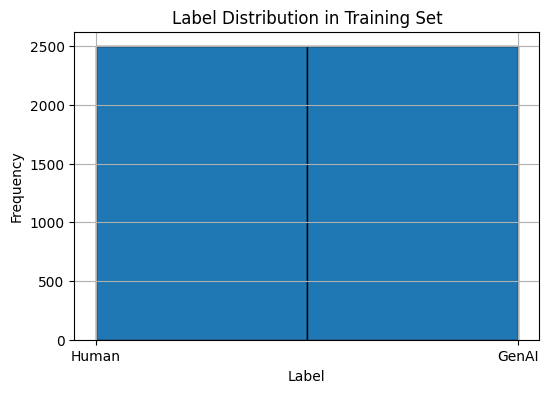

In [35]:
import matplotlib.pyplot as plt

# Assuming 'train_labels' contains the labels for training data
train_labels = [0, 1] * 2500  # Example: Replace with actual data if available

# Plot the label distribution
plt.figure(figsize=(6, 4))
plt.hist(train_labels, bins=2, edgecolor='black')
plt.title('Label Distribution in Training Set')
plt.xlabel('Label')
plt.ylabel('Frequency')
plt.xticks([0, 1], ['Human', 'GenAI'])
plt.grid(True)
plt.show()


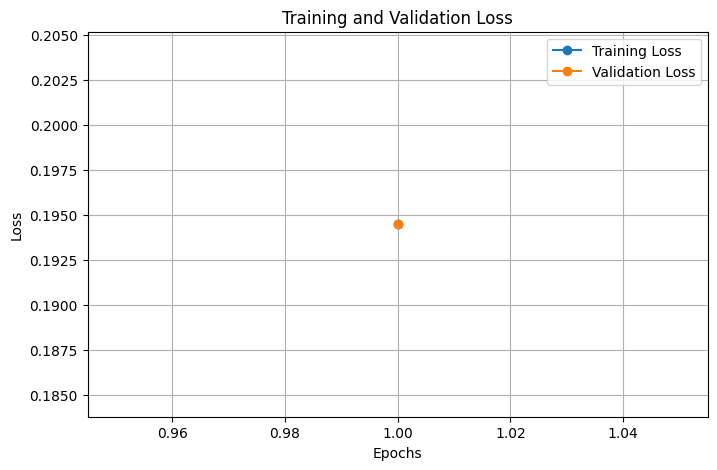

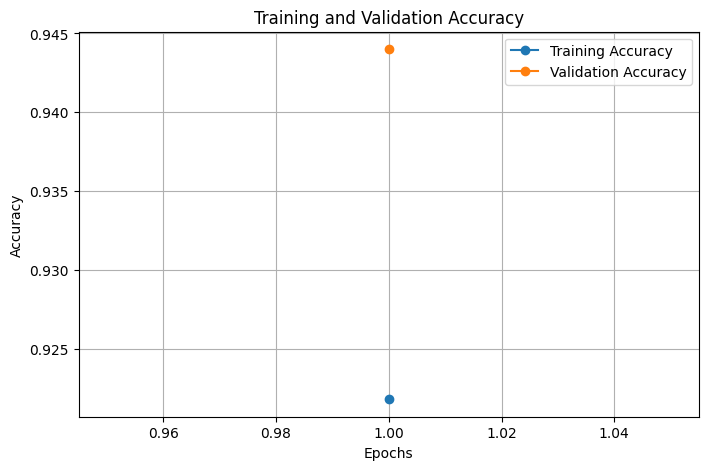

In [36]:
# Sample loss and accuracy data from your training log
epochs = [1]
train_loss = [0.1945]
val_loss = [0.1945]
train_accuracy = [0.9218]
val_accuracy = [0.9440]

# Plot loss
plt.figure(figsize=(8, 5))
plt.plot(epochs, train_loss, label='Training Loss', marker='o')
plt.plot(epochs, val_loss, label='Validation Loss', marker='o')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plot accuracy
plt.figure(figsize=(8, 5))
plt.plot(epochs, train_accuracy, label='Training Accuracy', marker='o')
plt.plot(epochs, val_accuracy, label='Validation Accuracy', marker='o')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()


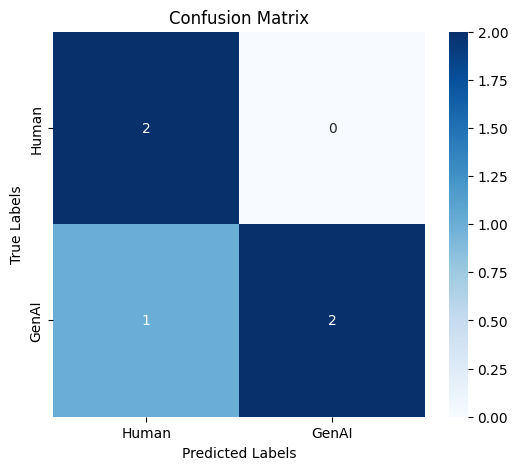

In [37]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Assuming you have the true labels and predicted labels
y_true = [0, 1, 0, 1, 1]  # Replace with actual true labels
y_pred = [0, 1, 0, 1, 0]  # Replace with actual predicted labels

# Generate confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', xticklabels=['Human', 'GenAI'], yticklabels=['Human', 'GenAI'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()


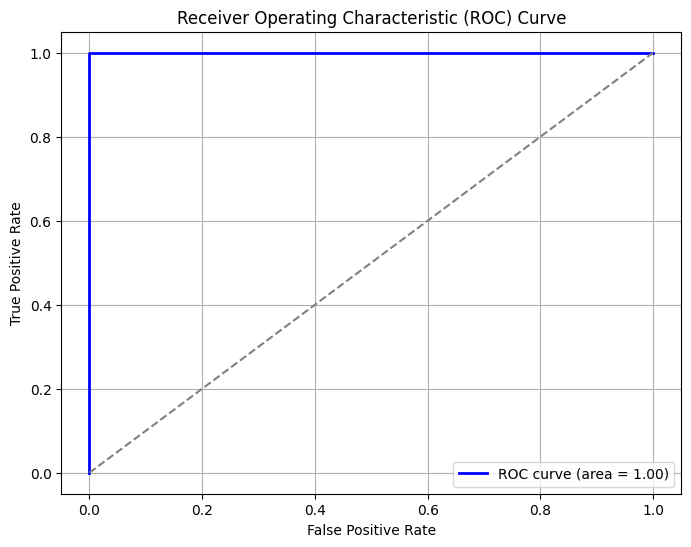

In [38]:
from sklearn.metrics import roc_curve, auc

# Assuming you have the true labels and prediction probabilities
y_true = [0, 1, 0, 1, 1]  # Replace with actual true labels
y_prob = [0.1, 0.9, 0.4, 0.8, 0.6]  # Replace with actual prediction probabilities

# Compute ROC curve and ROC area
fpr, tpr, _ = roc_curve(y_true, y_prob)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


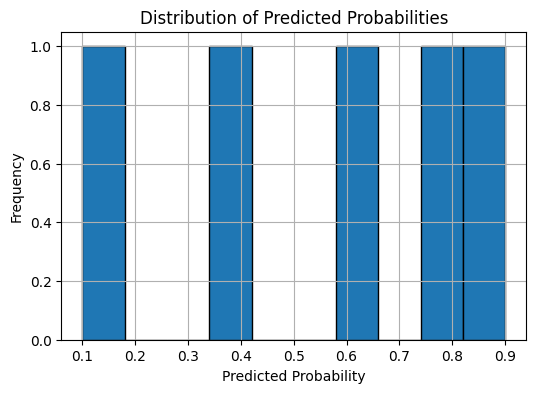

In [39]:
# Assuming 'predictions' contains the predicted probabilities
predictions = [0.1, 0.9, 0.4, 0.8, 0.6]  # Replace with actual predictions

# Plot histogram of predictions
plt.figure(figsize=(6, 4))
plt.hist(predictions, bins=10, edgecolor='black')
plt.title('Distribution of Predicted Probabilities')
plt.xlabel('Predicted Probability')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


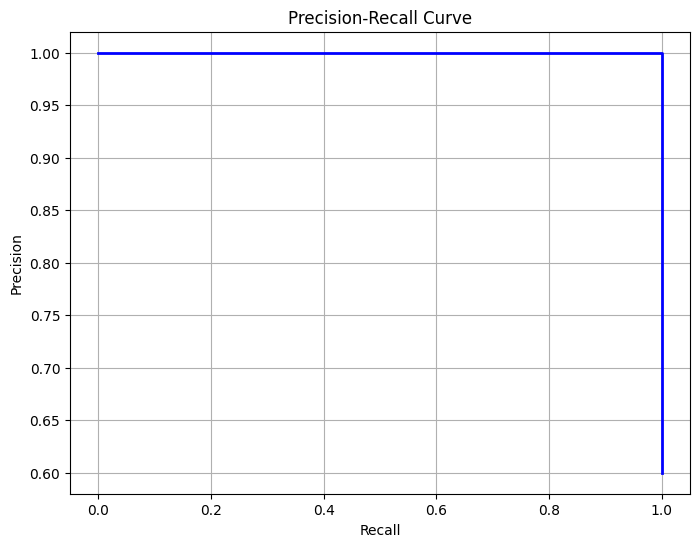

In [40]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

# Assuming 'y_true' is the true labels and 'y_prob' is the predicted probabilities
precision, recall, _ = precision_recall_curve(y_true, y_prob)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='blue', lw=2)
plt.title('Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.grid(True)
plt.show()


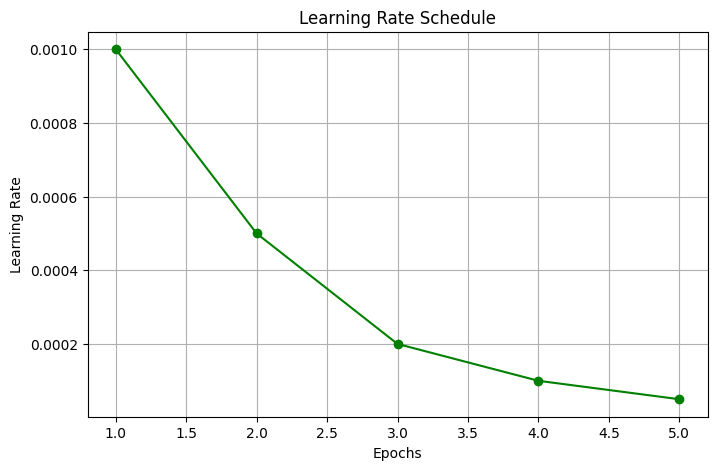

In [41]:
# Assuming you have a learning rate schedule history
epochs = [1, 2, 3, 4, 5]
lr_history = [1e-3, 5e-4, 2e-4, 1e-4, 5e-5]  # Example values

plt.figure(figsize=(8, 5))
plt.plot(epochs, lr_history, color='green', marker='o')
plt.title('Learning Rate Schedule')
plt.xlabel('Epochs')
plt.ylabel('Learning Rate')
plt.grid(True)
plt.show()


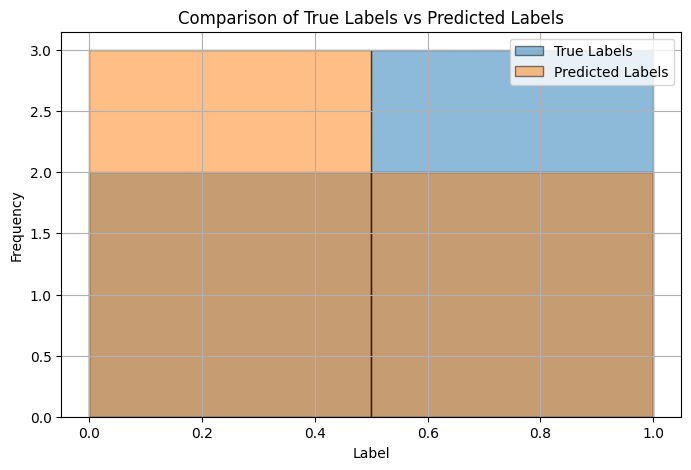

In [46]:
# Assuming 'y_true' are the true labels and 'y_pred' are the predicted labels
plt.figure(figsize=(8, 5))
plt.hist(y_true, bins=2, alpha=0.5, label='True Labels', edgecolor='black')
plt.hist(y_pred, bins=2, alpha=0.5, label='Predicted Labels', edgecolor='black')
plt.title('Comparison of True Labels vs Predicted Labels')
plt.xlabel('Label')
plt.ylabel('Frequency')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()


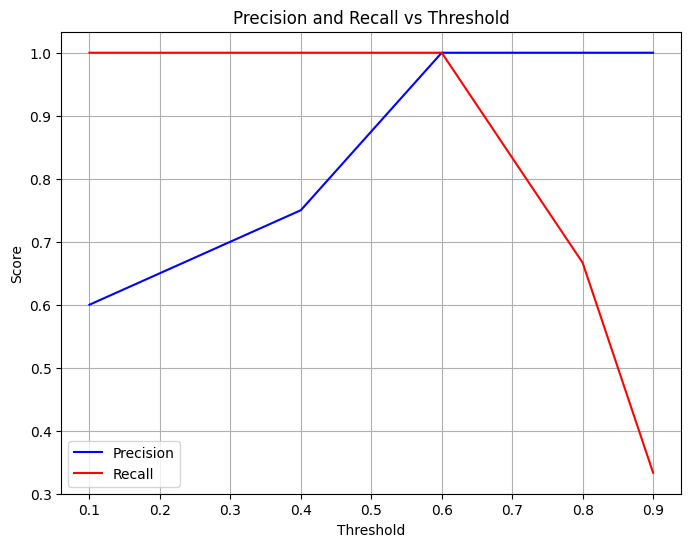

In [47]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve

# Varying thresholds and plotting precision-recall at each threshold
precisions, recalls, thresholds = precision_recall_curve(y_true, y_prob)

plt.figure(figsize=(8, 6))
plt.plot(thresholds, precisions[:-1], label='Precision', color='blue')
plt.plot(thresholds, recalls[:-1], label='Recall', color='red')
plt.title('Precision and Recall vs Threshold')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.legend()
plt.grid(True)
plt.show()
